<a href="https://colab.research.google.com/github/Marcozambeli/General/blob/main/Trabalho_1_EST_SE_Marco_Antonio_Zambeli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ENE057A - Estabilidade em Sistemas Elétricos de Potência Moódulo 1 - Geradores Síncronos
###Trabalho 1 - Marco Antonio de O. Zambeli 201369026c

Instruções:

• Data de submissão: 05/02/2021

• Resolução do trabalho deve ser individual submetida via Google Classroom.

• A resolução deve ser realizada em um notebook do Google Colab,

• Os tanto o raciocínio como os resultados dos cálculos devem ser devidamente explicados e comentados.





### 1. Seja o gerador de $144,6 [MVA]$, $18 [kV]$ e $60 [Hz]$ cujos parâmetros elétricos estão relacionados abaixo. Valores por unidade são baseados na potência e tensão nominais da máquina.
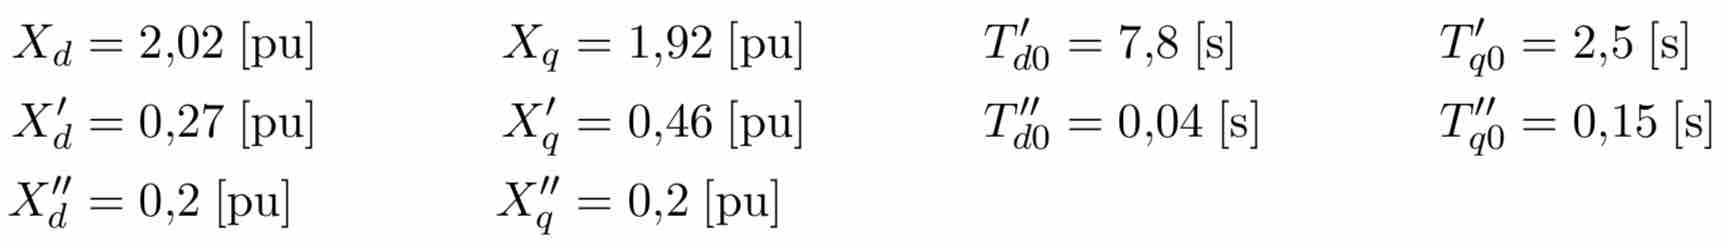
### (a) Assumindo que a máquina opera em vazio e tensão nominal:

In [ ]:
!pip install control

In [46]:
# Importando algumas bibliotecas do Python
import numpy as np
import control as ctrl
from scipy.signal import residue
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("display.precision", 4)


# Declarando os parametros fornecidos pelo enunciado
# Dados do Gerador:
G = 144.6   #[MVA]
V = 18      #[kV]
f = 60      #[Hz]

# cálculos de demais parametros
wb = 2*np.pi*f
Zb = V**2/G         #Zbase

# Reatâncias fornecidas em [pu]:
Xd =  2.02 
X1d = 0.27
X2d = 0.2 
Xq =  1.92 
X1q = 0.46
X2q = 0.2 

# cálculo das Indutâncias multiplicando as reatâncias por "conv":
Lb = Zb/Wb
Ld = Xd   *Lb  #[mA]
L1d = X1d *Lb
L2d = X2d *Lb
Lq = Xq   *Lb
L1q = X1q *Lb
L2q = X2q *Lb



# Ctes de tempo de circuito aberto 
#onde : "1"= transitória e "2" = subtransitória
T1do = 7.8    
T2do = 0.04   
T1qo = 2.5    
T2qo = 0.15   

# Constantes de tempo de curto-circuito
T1d = L1d/Ld*T1do   
T2d = L2d/L1d*T2do
T1q = L1q/Lq*T1qo   
T2q = L2q/L1q*T2qo  


# Parâmetros adicionais
rs = 0    #Considerando a resistencia do estator como sendo nula
vq0 = V

#### ( I ). Calcule as funções de transferência para as indutâncias operacionais $Ld(s)$ e $Lq(s)$ da máquina.

In [47]:
#definição da frequência complexa  𝑠  de Laplace.
s = ctrl.TransferFunction([1, 0], [1])

#de acordo com as definições das indutâncias operacionais Ld(s) e Lq(s),
#podemos calculá-las empregando a variável complexa s, definida anteriormente.
Lds = Ld*(1+T1d*s)*(1+T2d*s)/(1+T1do*s)/(1+T2do*s)
Lqs = Lq*(1+T1q*s)*(1+T2q*s)/(1+T1qo*s)/(1+T2qo*s)

In [48]:
#logo, a função de transferência da indutância operacional de eixo direto:
Lds

TransferFunction(array([0.00037088, 0.01287284, 0.01200596]), array([0.312, 7.84 , 1.   ]))

In [49]:
#logo, a função de transferência da indutância operacional de eixo  de quadratura:
Lqs

TransferFunction(array([0.00044577, 0.00757931, 0.01141161]), array([0.375, 2.65 , 1.   ]))

#### ( II ). Calcule as funções de transferência $Id(s)$ e $Iq(s)$ para a condição de curto-circuito trifásico franco nos terminais da máquina. Considere o modelo de máquina completo.


In [50]:
#Para dar prosseguimento ao calculo das FT Id(s) e Iq(s),define-se as funções  𝑉𝑑(𝑠) = -Vq0/s  e  𝑉𝑞(𝑠) = 0,
#representando o curto-circuito trifásico franco nos terminais da máquina:
Vqs = -vq0/s
Vds = 0

# De posse desses valores, pode-se calcular as correntes 𝐼𝑑(𝑠) e 𝐼𝑞(𝑠) através da solução dos circuitos equivalentes dos eixos 𝑑 e 𝑞.
# Na representaçao matematica de tais resolucoes (abaixo), cancelou-se os polos e zeros nas funções de transferência resultantes.
iDelta = ctrl.minreal(1/((rs + s*Lds)*(rs + s*Lqs) + wb**2*Lds*Lqs))
Ids = ctrl.minreal((wb*Lqs*Vqs - (rs + s*Lqs)*Vds)*iDelta)
Iqs = ctrl.minreal((-wb*Lds*Vds - (rs + s*Lds)*Vqs)*iDelta)

4 states have been removed from the model
4 states have been removed from the model
5 states have been removed from the model


In [51]:
#logo, corrente de eixo direto:
Ids

TransferFunction(array([-5.70857919e+06, -1.43446344e+08, -1.82967275e+07]), array([1.00000000e+00, 3.47091643e+01, 1.42154675e+05, 4.93294638e+06,
       4.60075405e+06, 0.00000000e+00]))

In [52]:
#logo, corrente de eixo em quadratura:
Iqs

TransferFunction(array([ 15142.4765903 , 107006.83383244,  40379.93727853]), array([1.00000000e+00, 1.70028986e+01, 1.42147903e+05, 2.41649111e+06,
       3.63833097e+06]))

#### ( III ). Encontre a representação por frações parciais de $Id(s)$ e $Iq(s)$, obtidas no item (II). Quais informações podem ser extraídas de tais representações?

In [53]:
#As funções de transferência serão decompostas em frações parciais usando a rotina residue da biblioteca scipy.signal
#Retornando vetores de resíduos, polos e constantes de polinômio direto. 
#Nos casos abordados aqui, as últimas constantes não são verificadas.
Id_r, Id_p, Id_k = residue(Ids.num[0][0], Ids.den[0][0])  #seleciona os num e dens armazenados
Iq_r, Iq_p, Iq_k = residue(Iqs.num[0][0], Iqs.den[0][0])

In [54]:
#utilizando a biblioteca pandas para facilitar na visualização de Id(s) decomposto:
pf_Id = {'polos': Id_p, 'residuos': Id_r}                    #cria um dicionario 
df_Id = pd.DataFrame(pf_Id, index=np.arange(1, Id_r.size+1)) #nº de linhas de acordo com o nº de residuos
df_Id

,polos,residuos
1,0.0000+0.0000j,-3.9769+0.0000j
2,-0.9592+0.0000j,-25.5121+0.0000j
3,-33.7500+0.0000j,-10.5926+0.0000j
4,0.0000+376.9911j,20.0408+0.5066j
5,0.0000-376.9911j,20.0408-0.5066j


In [55]:
#utilizando a biblioteca pandas para facilitar na visualização de Iq(s) decomposto:
pf_Iq = {'polos': Iq_p, 'residuos': Iq_r}
df_Iq = pd.DataFrame(pf_Iq, index=np.arange(1, Iq_r.size+1))
df_Iq

,polos,residuos
1,-1.6696+0.0000j,-0.0495+0.0000j
2,-15.3333+0.0000j,-1.0075+0.0000j
3,0.0000+376.9911j,0.5285-20.0627j
4,0.0000-376.9911j,0.5285+20.0627j


*** Análise das tabelas de Id e Iq vistas anteriormente: ***




>
*   Os **polos** definem o decaimento e a frequência dos modos de oscilação do sistema.
*   Já os **resíduos** definem os pesos de cada modo de oscilação na dinâmica do sistema.
*  Quanto maior for o módulo do polo, menor vai ser a cte de tempo associada (1/T). Assim indentifica-se as constentes de tempo mais rápidas (subtransitórias) de **Id** na **3ª linha** da tabela e de **Iq** na **2ª linha**.
* As constantes de tempo transitórias estao relacionadas aos demais polos nao nulos, ou seja para **Id** na **2ª linha** da tabela e para **Iq** na **1ª linha**.
* Os polos nulos estão relacionados a constantes (valor de regime permanente).
* Os pares de polos complexos conjugados estã associados a oscilações puras, já que a parte real dos mesmos é **nula** graças à ausência de resistência no estator da máquina (**rs=0**).




#### ( IV ). Refaça os itens (II) e (III) ignorando o efeito das variações de fluxo no estator nos eixos $dq$. Compare os resultados aproximados com os anteriores.

In [65]:
#eixo direto
Id = Vqs/(wb*Lds)
Id

TransferFunction(array([  -5.616, -141.12 ,  -18.   ]), array([0.13981743, 4.85294606, 4.52614108, 0.        ]))

In [66]:
#eixo quadratura
Iq = -Vds/(wb*Lqs)  # Iq é nulo, pois Vd é nulo
Iq

TransferFunction(array([0.]), array([1.]))

In [67]:
#eixo direto 
Idr, Idp, Idk = residue(Id.num[0][0], Id.den[0][0])

# tabela de pólos e residuos 
pfId = {'polos': Idp, 'residuos': Idr}
dfId = pd.DataFrame(pfId, index=np.arange(1, Idr.size+1))
dfId

,polos,residuos
1,0.0000,-3.9769
2,-0.9592,-25.5123
3,-33.7500,-10.6775


In [68]:
#eixo em quadratura 
Idr, Idp, Idk = residue(Iq.num[0][0], Iq.den[0][0])

# tabela de pólos e residuos 
pfIq = {'polos': Idp, 'residuos': Idr}
dfIq = pd.DataFrame(pfIq, index=np.arange(1, Idr.size+1))
dfIq

,polos,residuos


**Considerações sobre a simplificação no cálculo da corrente de curto**

Desprezando as variações rapidas de fluxo no estator (e também a resistência de armadura), as correntes passam a variar instantaneamente e a relação entre as correntes e tensão de armadura se tornam puramente algébricas.

Ao analisar os circuitos de eixo direto e o de quadratura, percebe-se que eles são equivalentes, uma vez que a tensão terminal é idêntica à tensão mocional em ambos eixos. De tal simplificação foram retiradas as relações matemáticas usadas nos boxes anteriores de código.

Nota-se a independencia entre $Id$ e $Iq$, uma vez que $Id$ depende das variáveis de eixo direto e $Iq$ depende daquelas do eixo em quadratura. Aplicando as funçoes forçantes $Vd(s)$ e $Vq(s)$, obtem-se as novas expressões para $Id(s)$ e $Iq(s)=0$ (graças ao valor nulo de Vd).

**Análise da tabela após a expansão em frações parciais**

 Uma das diferenças observadas durante a comparação entre $Id$ antes e depois da simplificação é que houve a redução do grau da função de tranferência de $5º$ para $3º$ ordem. Confrontando as duas tabelas de polos e resíduos, percebe-se que a simplificação eliminou o par de polos complexos conjugados (agora é puramente constante, sem parcelas CA) e os resíduos sao praticamente iguais aos obtidos na tabela mais completa anterior.

 Como conclusão da eficácia do método de simplificação por desconsideração da variação do fluxo no estator, percebe-se que o resultado final é equivalente ao do modelo mais completo. Pois como os polos na origem determinam o valor final das correntes, somente o resíduo é levado em consideraçao e o mesmo é equivalente nas duas análises, no caso $r=-3.9769$. 



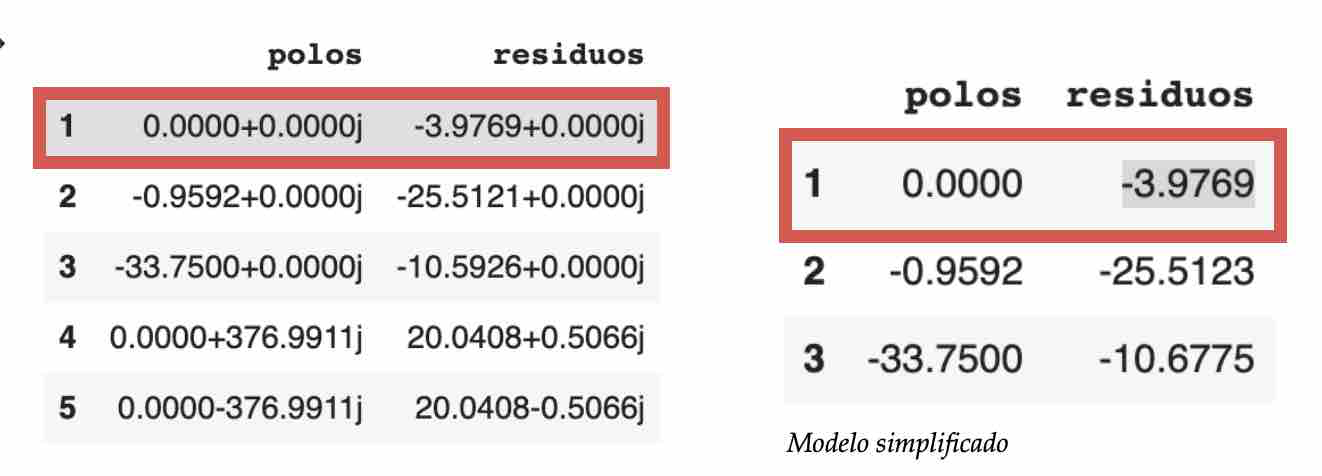

#### ( V ). Estime o valor de pico da corrente de curto-circuito na fase a durante o primeiro ciclo do curto.

### (b) Assumindo que a máquina opera com potência aparente nominal e fator de potência 0,9 (indutivo), descreva um procedimento de cálculos necessários para que o pico da corrente de curto seja calculado.


**Resolução da letra "B"**

Os cálculos da corrente de pico iniciam-se definindo o modelo do circuito equivalente tanto em regime permanente, quanto em regime transitório, para a máquina que opera com potência nominal nos instantes iniciais.
Assim:

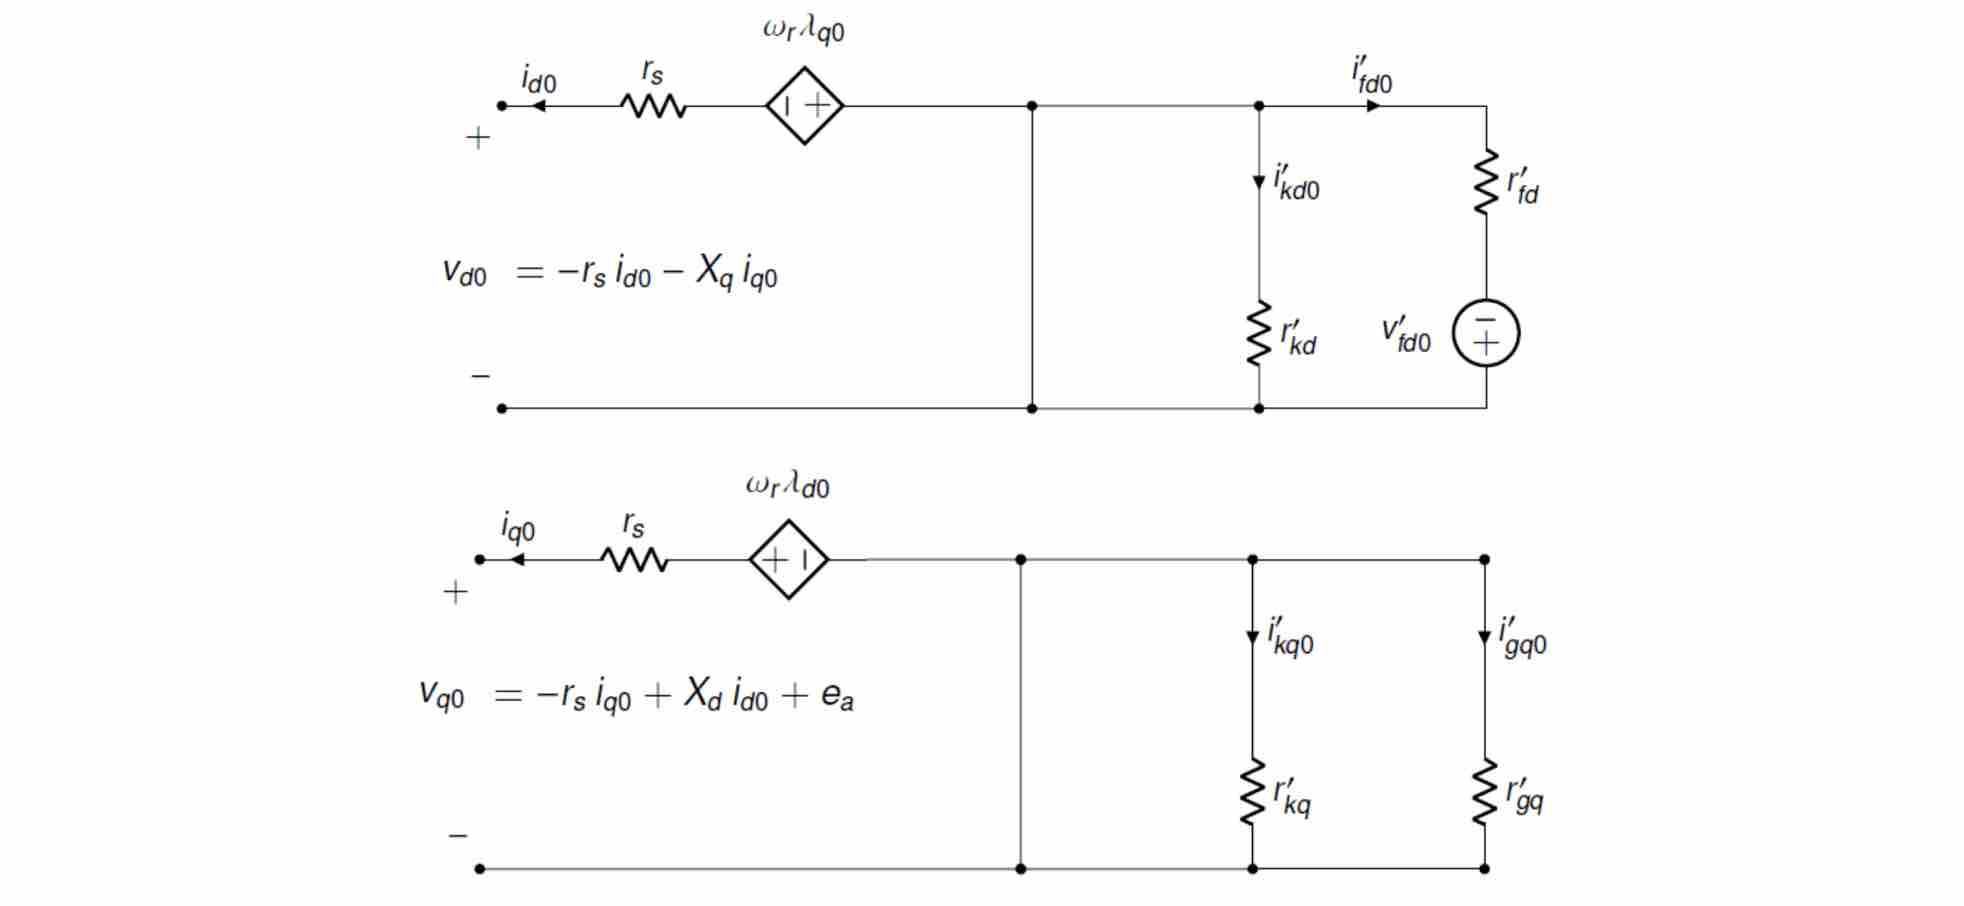

 Como a máquina está operando em condições equilibradas, as indutâncias foram substituidas por curtos-circuitos devido as correntes $Id$ e $Iq$ constantes se representadas no referencial $-dq$.

 As correntes nos circuitos $kd$, $kq$ e $gq$ serão nulas, pois não existem funções forçantes nestes circuitos. A única corrente circulante no circuito de eixo direto será aquela de excitação representada pela fonte Vfd0.
 
 De posse dessas correntes é possivel realizar o cálculo dos fluxos associados às tensões mocionais vistas pelo estator.

 Pela realização da análise por malhas do circuito linear, tem-se as equações:

* $V_{d0} = −r_s\cdot i_{d0} − X_q\cdot i_{q0}$ 

* $V_{q0} = −r_s\cdot i_{q0} − X_d\cdot i_{d0} + e_a$